# Lecture-10 Build a neural network from sractch

## Target: using python and numpy implement a neural network framework.

> Node:
+ forward: *Function*, how to calculate the inputs
+ backwards: *Function*, how to get the gradients when backpropogation
+ gradients: *Mapper*, the gradient map the this node of its inputs node
+ inputs: *List*, the input nodes of this node
+ outputs: *List*, the output node of this node
 

## 面向对象的方式来组织这个

In [31]:
def add(a, b):
    return a + b

In [32]:
var_int = 10
var_2_int = 20

In [33]:
add(var_int, var_2_int)

30

In [34]:
var_int = [100, 200] # 如果在C/Java里边，这句话根本就不能通过编译
var_2_int = [122, 122233, 1231]

In [35]:
add(var_int, var_2_int)

[100, 200, 122, 122233, 1231]

## Confusing -> 读你代码的人很困惑，当时间过去。。。，你自己也看不懂了

## 构建基类

In [36]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs # input_list <- C, Java <- 匈牙利命名法 -> Python 特别不建议
       # self.outputs = outputs # output_list 
        self.value = None 
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) # build a connection relationship
    
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
    
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [37]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [38]:
import numpy as np

In [39]:
X = np.array([1, 2, 3])

In [40]:
W = np.array([[1, 2], [2, 4], [3, 5]])

In [41]:
X.shape

(3,)

In [42]:
W.shape

(3, 2)

In [43]:
B = np.array([1, 3])

In [44]:
np.dot(X, W) + B

array([15, 28])

In [45]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)
    

In [46]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial

In [47]:
W1 = np.array([[1, 1], [1, 2], [1, 3]])
W2 = np.array([[1, 1], [0, 2], [1, 4]])

In [48]:
(W1.reshape(-1, 1) - W2.reshape(-1, 1)) ** 2

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]], dtype=int32)

In [49]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [50]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [51]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [52]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [53]:
from sklearn.datasets import load_boston

In [54]:
data = load_boston()

In [55]:
X_ = data['data']

In [56]:
y_ = data['target']

In [57]:
y_[0]

24.0

In [58]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [59]:
n_features = X_.shape[1]

In [60]:
n_hidden = 10

In [61]:
n_hidden_2 = 10

In [62]:
X.shape

(3,)

In [63]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [64]:
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

In [65]:
#W3, b3 = np.random.randn(n_hidden_2, 1), np.zeros(1)

## Build a graph connection 

### 1st. Build Nodes in this graph

In [66]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
#W3, b3 = Input(name='W3'), Input(name='b3')

### 2nd build connection relationship

In [67]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

## 我们可以把它的网络变得更复杂

In [68]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [69]:
graph = topological_sort(input_node_with_value)

In [70]:
graph

[Input Node: W2,
 Input Node: b1,
 Input Node: b2,
 Input Node: W1,
 Input Node: X,
 Input Node: y,

In [71]:
from sklearn.utils import resample

In [72]:
np.random.choice(range(100), size=10, replace=True)

array([22, 83, 47, 31, 82, 47, 53, 10, 84, 59])

In [73]:
def run(dictionary):
    return topological_sort(dictionary)

In [74]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
#         input_node_with_value = {  # -> feed_dict 
#             X: X_batch, 
#             y: y_batch, 
#             W1: W1.value, 
#             W2: W2.value, 
#             b1: b1.value, 
#             b2: b2.value,
#         }
        
#         graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 533.052
Epoch: 101, loss = 37.654
Epoch: 201, loss = 25.055
Epoch: 301, loss = 20.646
Epoch: 401, loss = 17.841
Epoch: 501, loss = 18.553
Epoch: 601, loss = 16.109
Epoch: 701, loss = 19.236
Epoch: 801, loss = 13.308
Epoch: 901, loss = 11.389
Epoch: 1001, loss = 11.586
Epoch: 1101, loss = 12.113
Epoch: 1201, loss = 10.025
Epoch: 1301, loss = 10.993
Epoch: 1401, loss = 9.242
Epoch: 1501, loss = 8.617
Epoch: 1601, loss = 10.572
Epoch: 1701, loss = 10.918
Epoch: 1801, loss = 7.473
Epoch: 1901, loss = 8.821
Epoch: 2001, loss = 9.825
Epoch: 2101, loss = 9.457
Epoch: 2201, loss = 8.586
Epoch: 2301, loss = 6.253
Epoch: 2401, loss = 6.587
Epoch: 2501, loss = 6.672
Epoch: 2601, loss = 9.001
Epoch: 2701, loss = 5.881
Epoch: 2801, loss = 6.479
Epoch: 2901, loss = 7.603
Epoch: 3001, loss = 7.131
Epoch: 3101, loss = 7.211
Epoch: 3201, loss = 8.826
Epoch: 3301, loss = 7.243
Epoch: 3401, loss = 7.831
Epoch: 3501, loss = 6.996
Epoch: 3601, loss = 6.485
Epoch: 3701, loss = 7.383
Epoch: 

In [75]:
import matplotlib.pyplot as plt

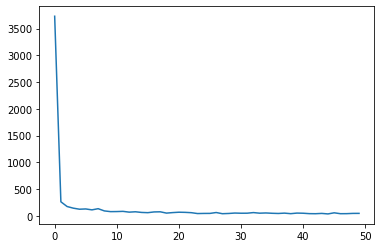

In [76]:
plt.plot(losses)

In [77]:
W1.value

array([[-2.04315946, -0.75891833,  0.2171435 , -1.85427256, -0.16242813,
        -0.33312016,  0.07179742, -0.46551488, -1.13524797, -0.80643328],
       [ 0.08773244,  0.88044096,  0.60377578, -0.07129671, -1.00386112,
         0.22454372,  0.49048211, -0.33959291,  1.65851787, -0.4784122 ],
       [ 0.90775673, -0.15256002, -0.1784398 ,  1.1963245 , -0.2000536 ,
        -1.78015919,  1.84314197, -1.54852663, -0.42052924,  0.65928267],
       [ 2.0483449 ,  0.76894044,  0.32497204, -0.41599036, -0.69045723,
        -1.38501316,  0.54633805, -0.14505729, -0.01578081, -0.30901086],
       [ 1.83962097,  1.16540789, -2.56535211,  0.41366723,  0.61111296,
        -1.96504243,  0.23922655,  0.36934871, -1.20202165, -0.953919  ],
       [-0.18968307,  1.9363424 , -0.47237313,  2.01658044,  1.13460878,
         2.03334273, -1.52626612,  0.25034258, -1.30993748,  1.52298117],
       [-0.73146926, -1.50215339,  0.63030287, -0.72979923, -1.94796063,
         1.14934419,  0.8178538 , -1.46604575

In [78]:
W2.value

array([[ 3.72917943],
       [ 9.39347513],
       [10.98783232],
       [ 5.53721265],
       [ 4.71927802],
       [ 4.40660599],
       [ 1.84250974],
       [ 2.64338316],
       [ 8.78830315],
       [ 8.53245979]])

In [79]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [80]:
x1 = Input()

In [81]:
x1.value = X_[1]

In [82]:
y_of_x1 =  Linear(Sigmoid(Linear(x1, W1, b1)), W2, b2)

In [83]:
W1.value.shape

(13, 10)

In [84]:
 def _sigmoid(x):
        return 1. / (1 + np.exp(-1 * x))

In [85]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([23.86846083])

In [86]:
y_[1]

21.6

In [87]:
y_of_x1